# Modelos usando tensorflow: Muestras por segundo

Recopilacion de modelos implementados principalmente usando tensorflow. 

Imports y herramientas usadas:

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 8 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Procedemos entontes a la carga y preprocesado de datos. 

In [16]:
datos_por_segundo = "../data/1-intermedia/resumen-comportamientos_Matilda_dataset_per_second.csv"

Comenzamos analizando los datos de entrada. Revisamos el tamaño, la forma y las columnas que tiene.

In [17]:
data_raw = pd.read_csv(datos_por_segundo)

In [18]:
# Do we have NaN values in data_raw?
print(f"NaN values: {data_raw.isna().sum().sum()}")

NaN values: 0


In [19]:
data_raw.describe()

,x_0,y_0,z_0,ODBA_0,x_1,y_1,z_1,ODBA_1,x_2,y_2,...,z_7,ODBA_7,x_8,y_8,z_8,ODBA_8,x_9,y_9,z_9,ODBA_9
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,...,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000
mean,0.215241,0.116638,0.758530,0.298850,0.214296,0.113839,0.752203,0.295632,0.213589,0.117898,...,0.754686,0.303678,0.210933,0.117080,0.757042,0.296563,0.210920,0.122132,0.755353,0.304522
std,0.374927,0.263871,0.297255,0.254621,0.380278,0.266080,0.321738,0.329812,0.377200,0.266825,...,0.297195,0.264788,0.378386,0.261031,0.300800,0.267159,0.377138,0.264529,0.295316,0.279301
min,-1.015600,-0.890600,-0.375000,0.007790,-1.046900,-1.265600,-3.906300,0.004187,-1.000000,-0.953100,...,-0.453100,0.003690,-1.546900,-0.984400,-0.421900,0.007767,-1.234400,-0.968800,-0.406300,0.004140
25%,0.015600,-0.046900,0.656300,0.101486,0.015600,-0.046900,0.656300,0.099504,0.015600,-0.046900,...,0.625000,0.104721,0.000000,-0.031300,0.656300,0.097410,0.000000,-0.031300,0.640600,0.101443
50%,0.125000,0.140600,0.875000,0.236155,0.125000,0.140600,0.875000,0.223923,0.125000,0.140600,...,0.875000,0.237535,0.125000,0.125000,0.875000,0.226552,0.125000,0.140600,0.875000,0.230173
75%,0.359400,0.281300,0.937500,0.419188,0.359400,0.296900,0.921900,0.409158,0.375000,0.296900,...,0.937500,0.419957,0.359400,0.296900,0.937500,0.397898,0.347700,0.296900,0.937500,0.412864
max,1.031300,1.250000,1.343800,2.029297,2.328100,1.125000,1.468800,7.951573,1.234400,0.968800,...,1.406300,1.908370,1.062500,1.031300,1.390600,1.986470,1.046900,1.125000,1.406300,2.283370


In [ ]:
data_raw.shape

(1240, 41)

In [ ]:
data_raw.columns

Index(['x_0', 'y_0', 'z_0', 'ODBA_0', 'x_1', 'y_1', 'z_1', 'ODBA_1', 'x_2',
       'y_2', 'z_2', 'ODBA_2', 'x_3', 'y_3', 'z_3', 'ODBA_3', 'x_4', 'y_4',
       'z_4', 'ODBA_4', 'x_5', 'y_5', 'z_5', 'ODBA_5', 'x_6', 'y_6', 'z_6',
       'ODBA_6', 'x_7', 'y_7', 'z_7', 'ODBA_7', 'x_8', 'y_8', 'z_8', 'ODBA_8',
       'x_9', 'y_9', 'z_9', 'ODBA_9', 'Comportamiento'],
      dtype='object')

# 1 - Analisis de datos
El primer paso es analizar los datos disponibles. En este caso, usamos seaborn para graficar la cantidad de muestras que tenemos por cada tipo de comportamiento en el dataset seleccionado. 

Text(0.5, 1.0, 'Comportamiento de Matilda')

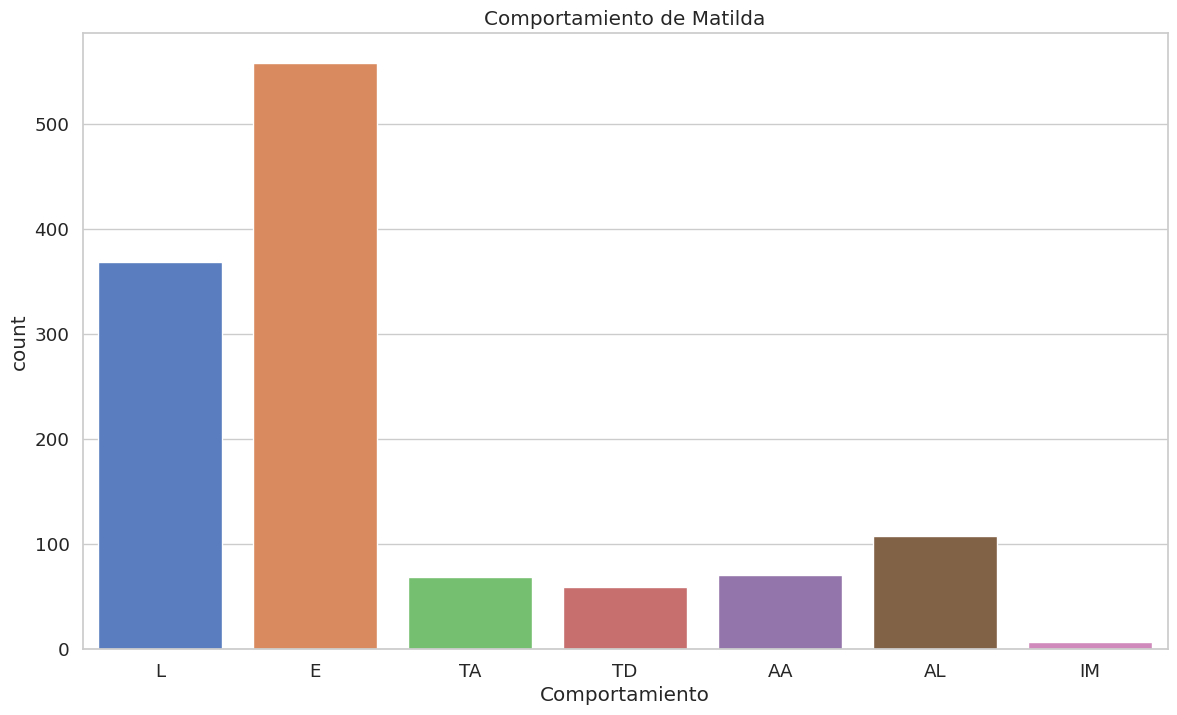

In [20]:
f = sns.countplot(x='Comportamiento', data=data_raw)
f.set_title('Comportamiento de Matilda')

Removemos los outliers, valores de ODBA fuera de rangos logicos generales. Vamos a considerar 3 desviaciones estandar, lo que se llama numero de z-scores. Esto es porque los valores fuera de 3 desviaciones estandard de la media no tienen mucha logica de ser. 

In [22]:
# Create new dataframe to calculate outliers
data_outlier_calc = data_raw.copy()

# Create new numpy array from ODBA columns
aux_combined_data = data_outlier_calc[['ODBA_0', 'ODBA_1', 'ODBA_2', 'ODBA_3', 'ODBA_4', 'ODBA_5', 'ODBA_6', 'ODBA_7', 'ODBA_8', 'ODBA_9']].to_numpy()
aux_combined_data = np.concatenate(aux_combined_data)

# Check combined data shape and head
print(aux_combined_data.shape)
print(aux_combined_data[:10])

# Print nan values in combined data
print(f"NaN values: {np.isnan(aux_combined_data).sum()}")

# Calculate mean and standard deviation
mean_ODBA = np.nanmean(aux_combined_data)
std_ODBA = np.nanstd(aux_combined_data)

# Print mean and standard deviation
print(f"Mean: {mean_ODBA}")
print(f"Standard deviation: {std_ODBA}")

# Calculate z-score for each ODBA value
for i in range(10):
    column_name = f'ODBA_{i}'
    data_outlier_calc[column_name + '_zscore'] = (data_outlier_calc[column_name] - mean_ODBA) / std_ODBA

# Print first 5 rows of the new dataframe
print(data_outlier_calc.head())

# Create new dataframe to filter outliers
data_no_outliers = data_outlier_calc.copy()

# Filter outliers by z-score outside of -3 and 3
for i in range(10):
    column_name = f'ODBA_{i}'
    data_no_outliers = data_no_outliers.loc[data_no_outliers[column_name + '_zscore'].abs() <= 3]

# Clean z-score columns
data_no_outliers = data_no_outliers.drop(columns=['ODBA_0_zscore', 'ODBA_1_zscore', 'ODBA_2_zscore', 'ODBA_3_zscore', 'ODBA_4_zscore', 'ODBA_5_zscore', 'ODBA_6_zscore', 'ODBA_7_zscore', 'ODBA_8_zscore', 'ODBA_9_zscore'])

# Print the shape of both dataframes
print(f"Original data shape: {data_raw.shape}")
print(f"Data without outliers filtered by ODBA value: {data_no_outliers.shape}")


(12400,)
[0.83021 1.28341 1.12711 1.17411 1.29901 0.83021 0.90831 0.65841 0.55527
 0.39261]
NaN values: 0
Mean: 0.2944537333333333
Standard deviation: 0.2669794553346632
      x_0     y_0     z_0    ODBA_0     x_1     y_1     z_1    ODBA_1     x_2  \
0  0.0781  0.0781  0.9375  0.830210 -0.1563  0.2031  1.0313  1.283410 -0.0625   
1 -0.0625 -0.1406  1.0000  0.237990  0.0313  0.0469  0.7031  0.450650  0.0469   
2 -0.0469  0.3906  0.8281  0.591150 -0.1094  0.3438  0.9688  0.465190 -0.0625   
3 -0.1875 -0.1250  0.9375  0.174450 -0.1875 -0.0938  0.9531  0.158850 -0.1563   
4 -0.2500 -0.0313  0.9688  0.225593 -0.2656 -0.0469  0.8750  0.234887 -0.2500   

      y_2  ...  ODBA_0_zscore  ODBA_1_zscore  ODBA_2_zscore  ODBA_3_zscore  \
0  0.2344  ...       2.006732       3.704241       3.118803       3.294846   
1  0.3125  ...      -0.211491       0.585050       1.341812       0.467438   
2  0.1719  ...       1.111307       0.639511       0.112504      -0.706960   
3 -0.1250  ...      -0.449487  

En el analisis inicial realizado para datos por fila simple, fueron registrados con distintos puntos de colores de acuerdo a los valores medidos de _X_, _Y_ y _Z_ vs el _ODBA_. En este caso, como la cantidad de entrada es 40, no podemos realizar el mismo grafico. Lo que si podriamos es graficar los valores promedios medidos durante el segundo en particular.

# 2- Preparacion de datos

Procedemos entonces con el siguiente paso: escalar los datos para que tengan valores entre -1 y 1, para darle de ingesta al modelo de red neuronal, cuyas capas de entrada reciben valores continuos entre esos valores, usando el objeto MinMaxScaler de la librería Scikit Learn.  

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the data
scaled_data = scaler.fit_transform(data_no_outliers.select_dtypes(include='float'))

print(f"scaled_data type: {type(scaled_data)}")

# Convert the numpy array to a dataframe
scaled_df = pd.DataFrame(scaled_data, columns=data_no_outliers.select_dtypes(include='float').columns)
print(f"scaled_df type: {type(scaled_df)} scaled_df shape: {scaled_df.shape}")

# Append Comportamiento column to scaled dataframe
scaled_df['Comportamiento'] = data_no_outliers['Comportamiento'].values

# Print the scaled dataframe
print(scaled_df.shape)


scaled_data type: <class 'numpy.ndarray'>
scaled_df type: <class 'pandas.core.frame.DataFrame'> scaled_df shape: (1171, 40)
(1171, 41)


Una vez esten escalados los datos, separamos en los sets de entrenamiento y pruebas. 

In [24]:
# Perform test-train split
train_data, test_data = train_test_split(scaled_df, test_size=0.2, random_state=RANDOM_SEED)

# Print the shapes of the train and test data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Prepare training and validation data for model.fit()
X_train = train_data.drop(columns=['Comportamiento'])
y_train = train_data['Comportamiento']
X_test = test_data.drop(columns=['Comportamiento'])
y_test = test_data['Comportamiento']


Train data shape: (936, 41)
Test data shape: (235, 41)


Lo ultimo que tenemos que hacer es codificar los valores de salida para mapearlos a una neurona de salida por cada categoria. 

In [25]:
from sklearn.preprocessing import LabelEncoder

# Convert the target variable to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

Definimos el modelo a generar.

In [ ]:
# Create new model with 40 columns as input, "Comportamiento" as cathegorical output, and 2 hidden layers with 20 and 10 neurons

model = keras.Sequential([
    keras.layers.Dense(40, input_shape=(40,), activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(units=7, activation='softmax')
])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
Total params: 2,747
Trainable params: 2,747
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo y lo entrenamos. 

In [ ]:
# Compile and fit the model with the numerical labels
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

training_history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=1, verbose=1, use_multiprocessing=True)


Epoch 1/100
936/936 [==============================] - 1s 910us/step - loss: 1.3068 - accuracy: 0.4893
Epoch 2/100
936/936 [==============================] - 1s 972us/step - loss: 1.0519 - accuracy: 0.5609
Epoch 3/100
936/936 [==============================] - 1s 892us/step - loss: 0.9529 - accuracy: 0.6314
Epoch 4/100
936/936 [==============================] - 1s 919us/step - loss: 0.8870 - accuracy: 0.6720
Epoch 5/100
936/936 [==============================] - 1s 934us/step - loss: 0.8574 - accuracy: 0.6774
Epoch 6/100
936/936 [==============================] - 1s 936us/step - loss: 0.8315 - accuracy: 0.6902
Epoch 7/100
936/936 [==============================] - 1s 940us/step - loss: 0.8171 - accuracy: 0.6838
Epoch 8/100
936/936 [==============================] - 1s 911us/step - loss: 0.7862 - accuracy: 0.7019
Epoch 9/100
936/936 [==============================] - 1s 941us/step - loss: 0.7815 - accuracy: 0.7019
Epoch 10/100
936/936 [==============================] - 1s 944us/step - l

Guardamos el modelo para referencia a futuro.

In [ ]:
import datetime
# Save model with the name "model_" + the current date and time as h5 file
model.save("../models/model_data_per_second_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S") + ".h5")

# model.save("model_data_per_second_202402020202.h5")

---

## Training checkpoint! 
Arriba se guardo el modelo recientemente entrenado, salido del horno... Desde aca en adelante podemos cargarlo para revisarlo mejor. (o no, si ya estaba cargado)

In [26]:

import tensorflow as tf
from tensorflow import keras
# Load model
model = keras.models.load_model('../models/model_data_per_second_202402020202.h5')

In [27]:
from sklearn.preprocessing import LabelEncoder

# Convert the target variable to numerical labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)


# Evaluate the model with the one-hot encoded target variable
model.evaluate(X_test, y_test_encoded)


2024-03-14 22:53:46.441615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


8/8 [==============================] - 0s 2ms/step - loss: 2.5723 - accuracy: 0.6043


[2.5723276138305664, 0.6042553186416626]

Vemos que esta interpretacion base no se comporta del todo bien que digamos, un 60% de accuracy nada mas con el set de prueba. Igual podemos ver que capaz un problema que no corregimos fue la desproporcionalidad de muestras de cada evento en la celda superior. Podriamos emparejar los numeros de muestra para ver que tan bien se comporta esta red base. 

<AxesSubplot:xlabel='True Label', ylabel='count'>

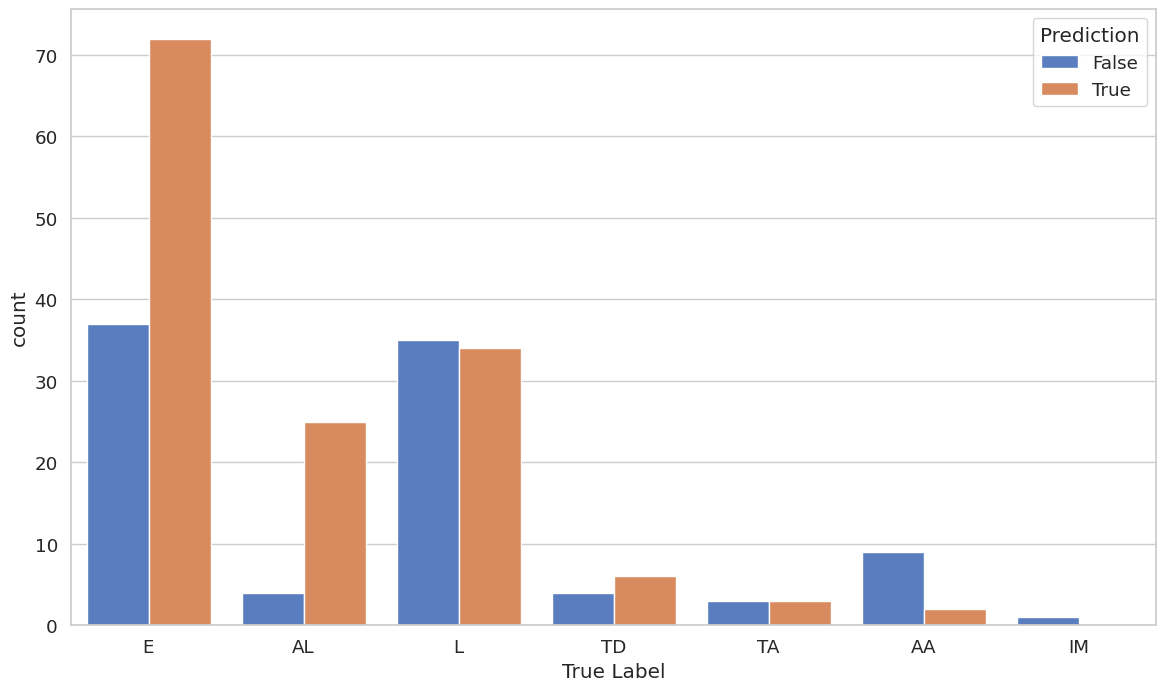

In [30]:
import numpy as np

# Get the predicted labels from the model
y_pred = model.predict(X_test)

# Convert the probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert the encoded labels back to their original categories
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred_labels)

# Create a DataFrame with the true labels and predicted labels
results_df = pd.DataFrame({'True Label': y_test_decoded, 'Predicted Label': y_pred_decoded})

# Add a column to indicate if the prediction was correct or incorrect
results_df['Prediction'] = results_df['True Label'] == results_df['Predicted Label']

# Plot the results using seaborn
sns.countplot(x='True Label', hue='Prediction', data=results_df)


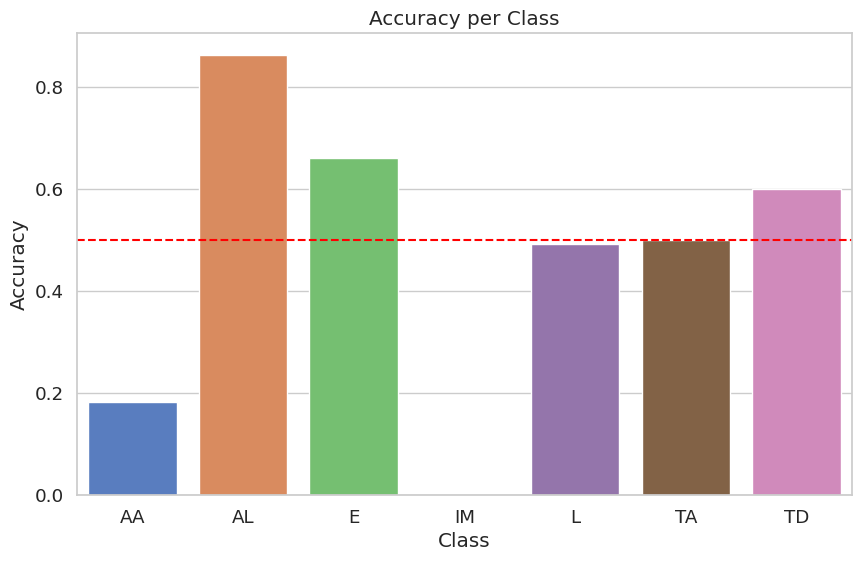

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy per class
accuracy_per_class = results_df['True Label'] == results_df['Predicted Label']
accuracy_per_class = accuracy_per_class.groupby(results_df['True Label']).mean()

# Plot the graph
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_per_class.index, y=accuracy_per_class.values)
plt.axhline(y=0.5, color='red', linestyle='--')

plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.show()


In [1]:
!python --version

Python 3.11.8
